**Danylo Redka (14795051)
Sergey Romadin (14988585)
Oksana Harapyn (14711133)**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
!{sys.executable} -m pip install mglearn
import mglearn

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVR, OneClassSVM
from sklearn.decomposition import PCA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 9.4 MB/s eta 0:00:00


**Mining Data**

In [ ]:
gas2011 = pd.read_csv("gt_2011.csv")
gas2012 = pd.read_csv("gt_2012.csv")
gas2013 = pd.read_csv("gt_2013.csv")
gas2014 = pd.read_csv("gt_2014.csv")
gas2015 = pd.read_csv("gt_2015.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'gt_2011.csv'

**Preprocessing Data**

Adding additional numerical variable: year, to each of the tables.

In [ ]:
gas2011["Year"]=2011
gas2012["Year"]=2012
gas2013["Year"]=2013
gas2014["Year"]=2014
gas2015["Year"]=2015

Checking dataset for missing values, zero values. Making sure that each collumn in the dataset has a proper type.

In [ ]:
data = pd.concat([gas2011, gas2012, gas2013, gas2014, gas2015], axis=0)
check1=pd.concat([data.dtypes, data.isnull().sum(),data.isna().sum()], axis=1)
check1.columns = ["Data type","Null found", "NA found"]
print(check1)
print(data.describe())

**Data Exploration**

Checking distribution of the features. Most of the graphs seem to be either skewed or multimodal. Considering the density lines of the features for each year, this effect is not caused by the year difference. Therefore data may have hidden subpopulations.

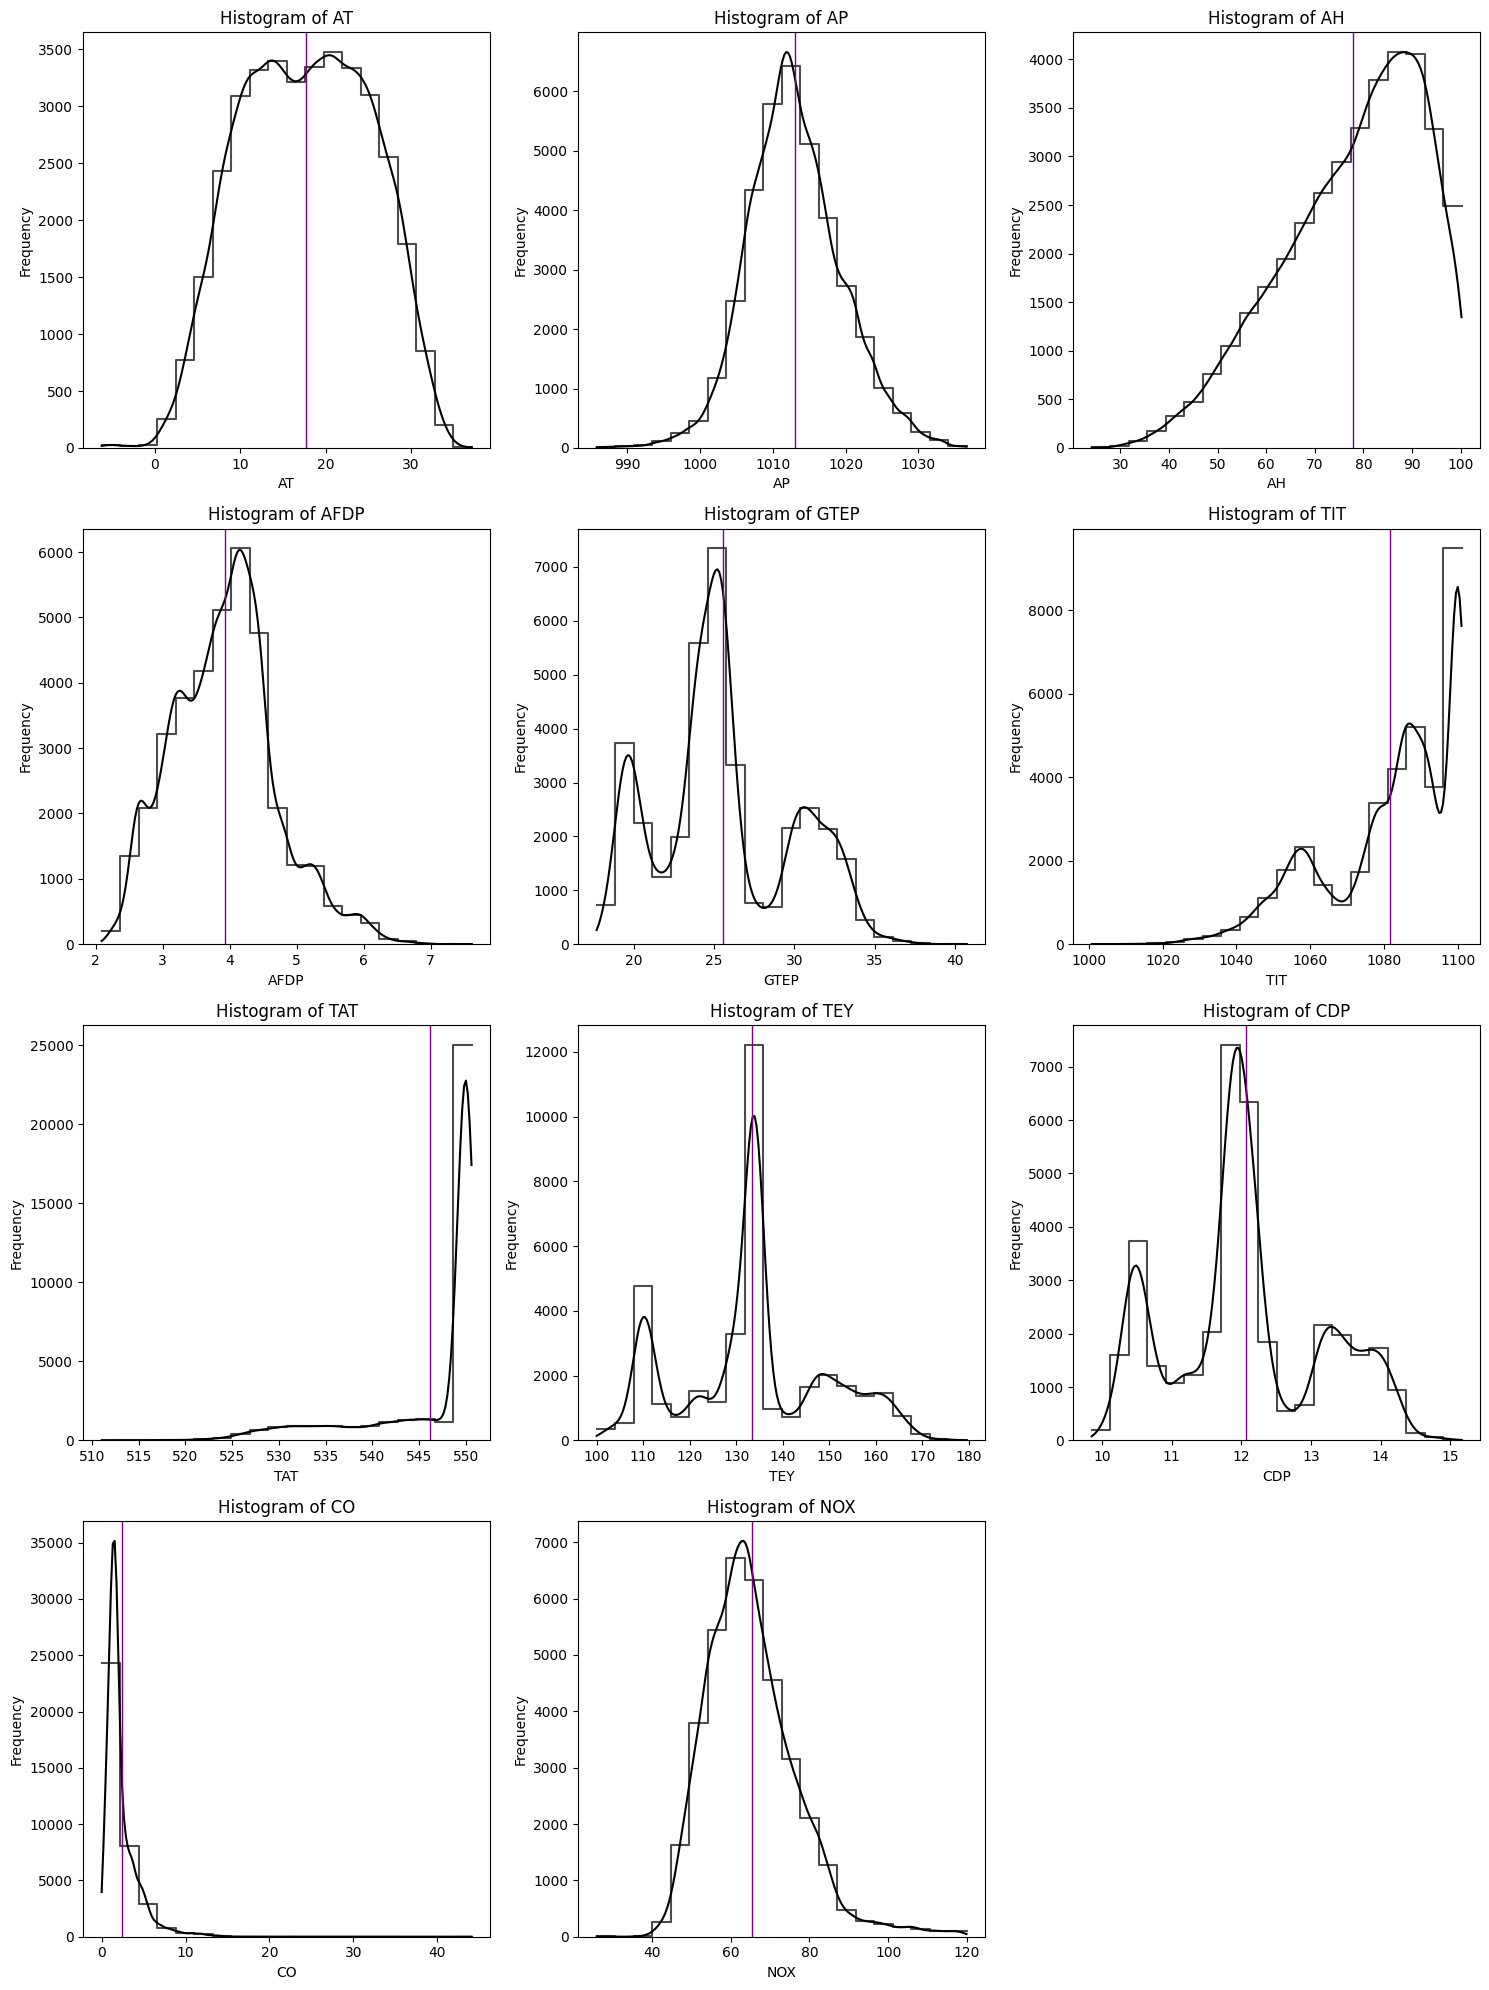

In [ ]:
num_features = len(data.columns)-1
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, 20))
axes = axes.ravel()

for i, column in enumerate(data.drop(columns=["Year"]).columns):
    sns.histplot(data[column], bins=20, kde=True, ax=axes[i], alpha=0.7, element="step", fill=False, color="black")
    mean_value = data[column].mean()
    axes[i].axvline(mean_value, color='purple', linewidth=1)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

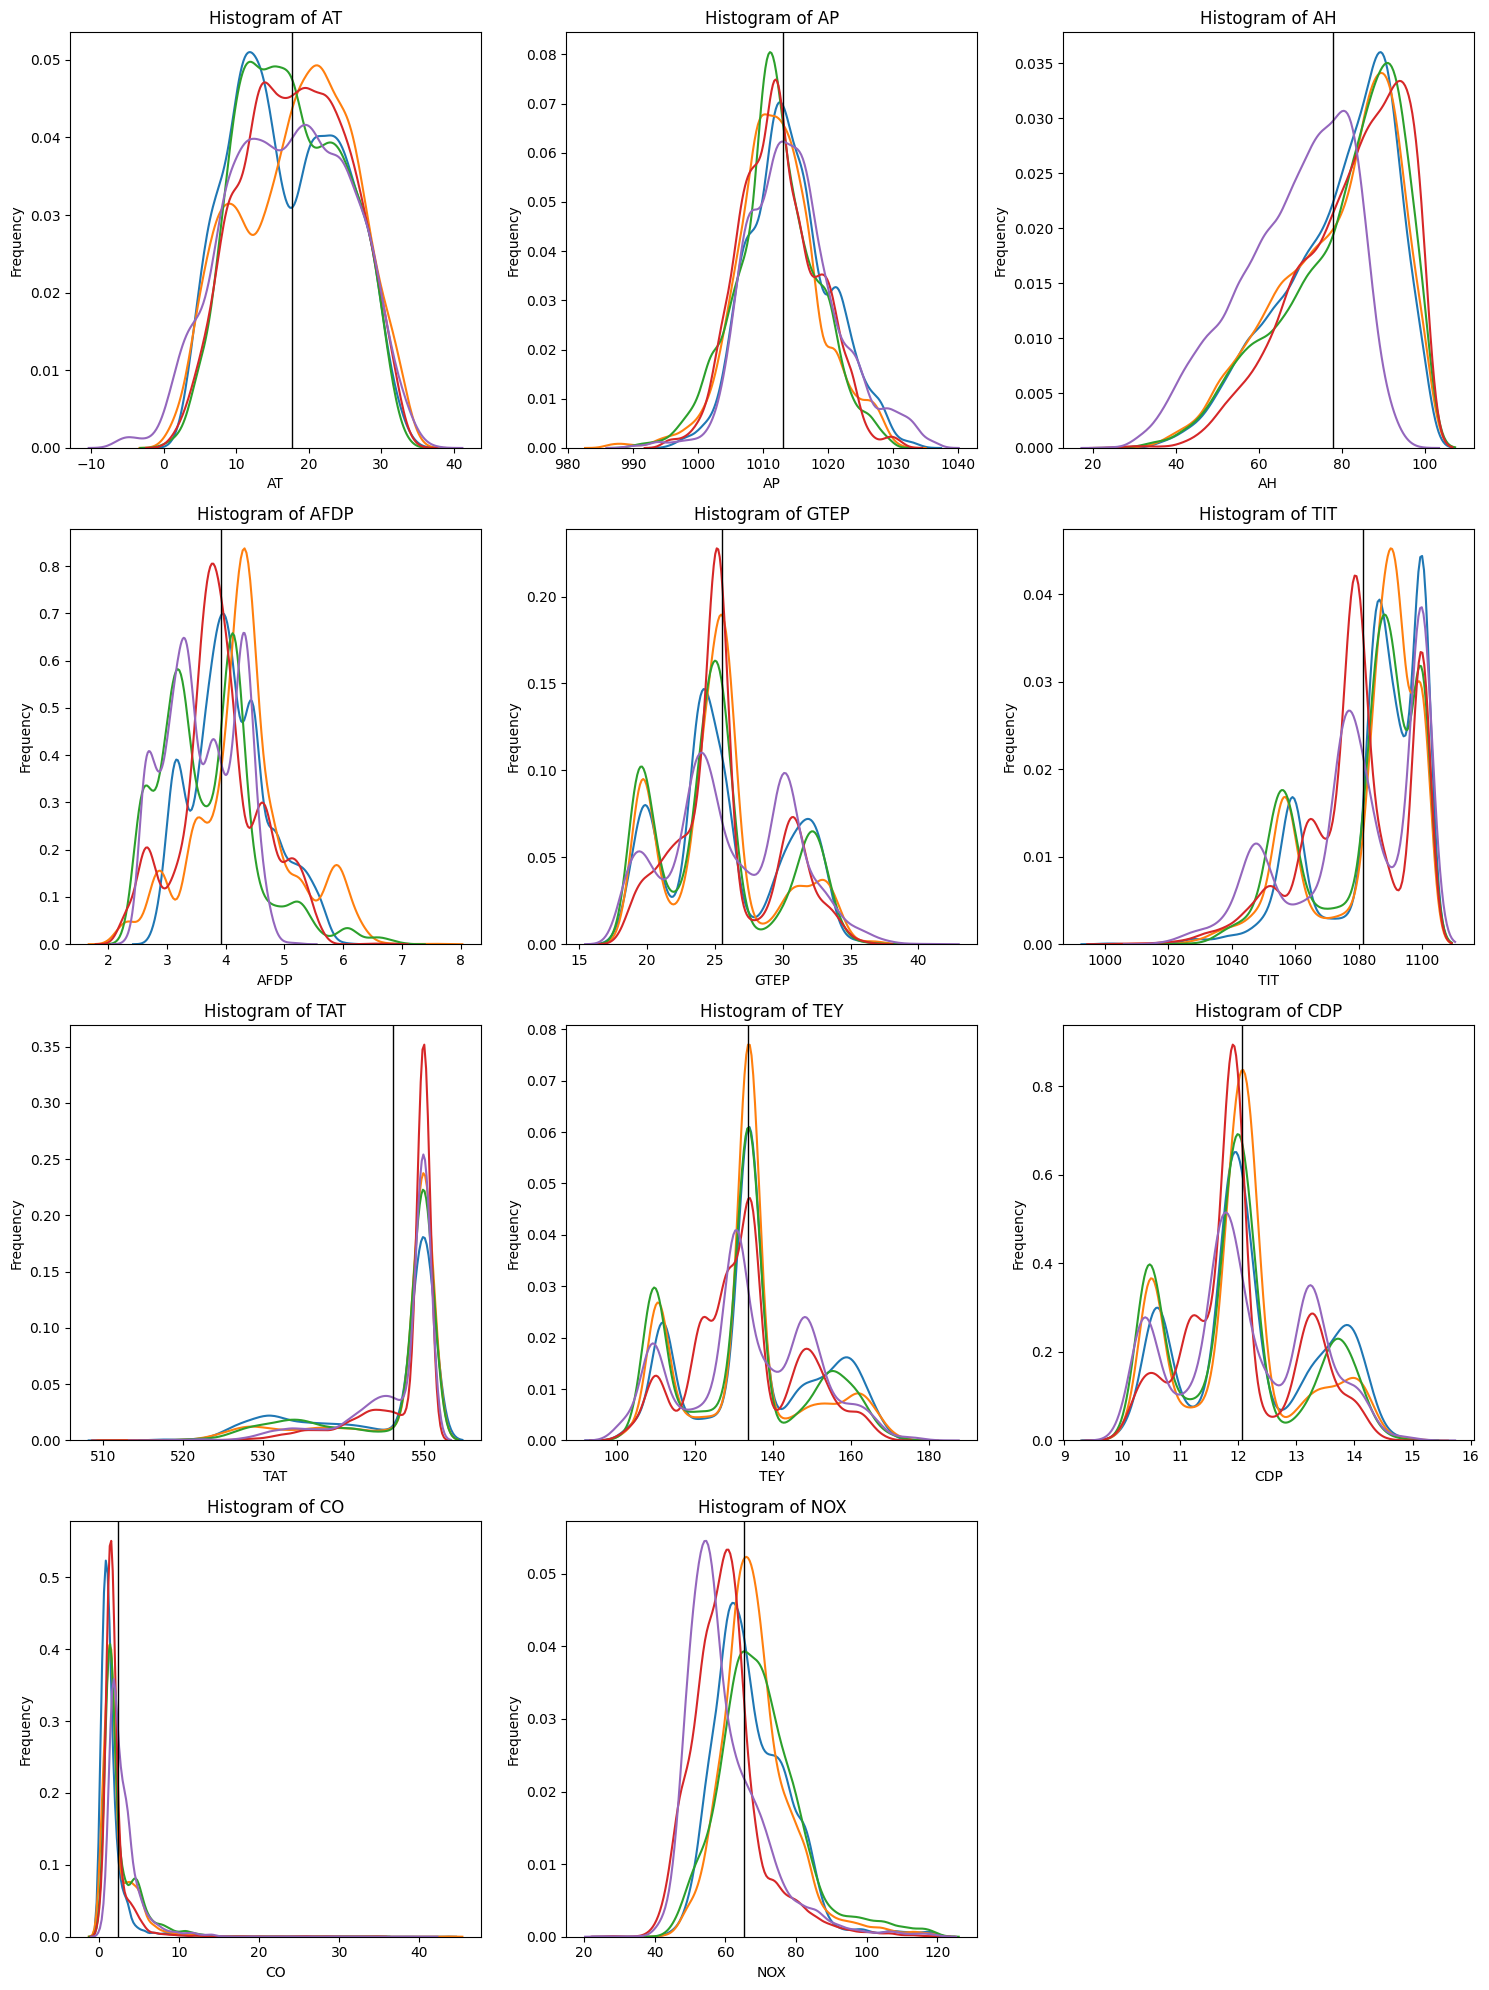

In [ ]:
num_features = len(data.columns)-1
fig, axes = plt.subplots(nrows=(num_features // 3) + 1, ncols=3, figsize=(15, 20))
axes = axes.ravel()

for i, column in enumerate(data.drop(columns=["Year"]).columns):
    for year in data['Year'].unique():
        sns.kdeplot(data[data['Year'] == year][column], ax=axes[i], label=str(year))
        mean_value = data[column].mean()
    axes[i].axvline(mean_value, color='black', linewidth=1)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

We are using IQR method for the outline detection, instead of z-score, since we have large dataset. IQR method also better at handling skewed  and multimodal data.

As we see the percentage of outliers in our data detected by IQR method is quite high.

Considering the nature of the data and the amount of possible outliers, we decided not to exclude them from the data. Different subpopulations within the data and its natural high variability might play important role in accurate refflection of the dataset.

Log transformation wouldn't be used to the whole dataset, due to its multimodality.

In [ ]:
print("Percentage of outliers detected by IQR method by column")
for i, column in enumerate(data.drop(columns=["Year"]).columns):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    filtered = data[(data[column] >= Q1 - 1.5*IQR)]
    filtered = filtered[(filtered[column] <= Q1 + 1.5*IQR)]
    print(column, "-", round(((data[column].size-filtered[column].size)*100)/data[column].size, 2))


Percentage of outliers detected by IQR method by column
AT - 4.7
AP - 11.83
AH - 1.79
AFDP - 10.03
GTEP - 9.32
TIT - 0.86
TAT - 13.49
TEY - 12.47
CDP - 12.33
CO - 17.18
NOX - 11.85


It was decided to examine scatterplots of each feature in order to spot some outliers manually. we come to the conclusion that:
- AT<0
- AP>1030
- AH<30
- AFDP>7
- GTEP>37
- TIT<1020
- TAT<515
- CO>25
- NOX<40

Should be considered as outliers.

In [ ]:
sns.pairplot(data.drop(columns=["Year"]))
plt.show()

Considering the nature of our data we replaced our outliers with the mode. With the manual selection of the outliers, we changed our data insignificantly - around 1% in each column

In [ ]:
restrictions = ["<0", ">1035", "<30", ">7", ">37", "<1020", "<515", None, None, ">25", "<40"]
i=0
n=len(data.index)

data_cleaned = data.copy()

for i, column in enumerate(data_cleaned.drop(columns=["Year"]).columns):
    if restrictions[i] is None:
        print(column, "- no changes")
    elif restrictions[i][0]=="<":
        limit=float(restrictions[i][1:])
        print(column, "-", round(len(data[data[column]<limit])*100/n, 4))
        data_cleaned.loc[data_cleaned[column]<limit, column]=random.choice(data_cleaned[column].mode())
    else:
        limit=float(restrictions[i][1:])
        print(column, "-", round(len(data[data[column]>limit])*100/n, 4))
        data_cleaned.loc[data_cleaned[column]>limit, column]=random.choice(data_cleaned[column].mode())

Constructing correlation map.

AT, AP. AH - carry low correlations -> valuable to the dataset

TAT, AFDP - low to medium corelations with other features

GTEP, TIT, TEY, CDP - high corelation among each other. Probably worth choosing one variable like GTEP.

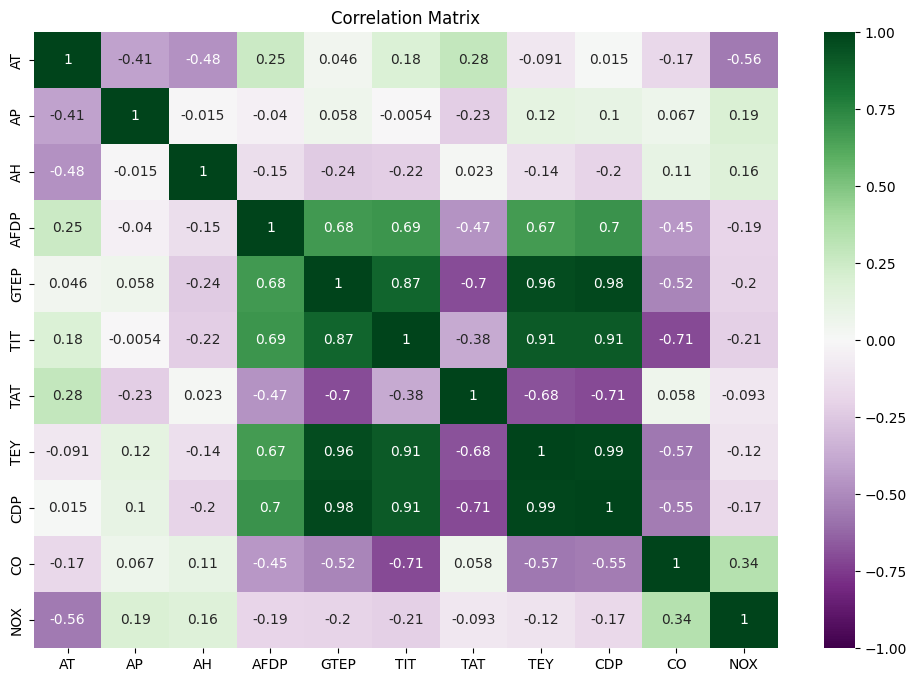

In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = data.drop(columns=["Year"]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='PRGn', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Regresion**

Dividing dataset. In protocol we are asked to use first three years of the data as training set and the rest two for testing. Therefore, we wouldn't be using random test split or Cross Validation.

In [ ]:
data_train=data_cleaned.head(pd.concat([gas2011, gas2012, gas2013], axis=0).shape[0])
X_train = data_train.drop(columns=["CO", "NOX"])
y1_train = data_train[ "CO"]

data_test=data_cleaned.tail(pd.concat([gas2014, gas2015], axis=0).shape[0])
X_test = data_test.drop(columns=["CO", "NOX"])
y1_test = data_test[ "CO"]

We have medium-sized, low-dimensional dataset. Data is continuous, has high variability. Taking this into account, we consider that the it would be reasonable to apply:

- Linear model. Standart scaling and log transformation will be applied to the data, due to numerous outliers.  Feature selection applied.

- Forest models. Considering the nature of the data, we expect this model to have the highest accuracy.  

**Forest Models**

We will start with the forest models since they don't require any additional transformations or scaling of our data. Our work with them will be  build in the next way:
1) Building the model without any parameter settings applied. This will help us to understand how the model is doing in general and what problems does it face.
2) Parameter tuning, including GridSeachCV in order to find best parameters.

a) Random Forests. As can be seen from the accuracy of our data, there is the overfit with accuracy of the training set being 0.978. The ranges for the parameters was choosen in the following way:
- n_estimators: 100 is a good starting point; after playing with the parameters it becomes obvious that n_estimator greater than 300 results only in more memory and time consumption. Therefore range(100, 300) is taken.
- max_features: following the good rule of thumb for regression max_features=log2(n_features). Therefore 3 is taken.
- max_depth: additional feature that will decrease code running time and resolve the problem of overfitting. It was observed that max_depth of original tree without any restrictions was around 30. Taking max_depth <10 is pointless, since gradient boosted regression model will have better perfomance with swallow trees. Therefore range(10,25) is taken.


In [ ]:
rf_no_par = RandomForestRegressor(random_state=0)
rf_no_par.fit(X_train, y1_train)
y1_pred=rf_no_par.predict(X_test)
print("Accuracy on training set: {:.3f}".format(rf_no_par.score(X_train, y1_train)))
print("Accuracy on test set: {:.3f}".format(rf_no_par.score(X_test, y1_test)))

Accuracy on training set: 0.974
Accuracy on test set: 0.467


In [ ]:

param_grid = {"n_estimators": range(100, 300, 50), "max_features" : [3], "max_depth": range(10, 25, 5)}
rf_with_par = GridSearchCV(rf_no_par, param_grid=param_grid)
rf_with_par.fit(X_train, y1_train)
y1_pred=rf_with_par.predict(X_test)
best_params = rf_with_par.best_params_
print("Accuracy on training set: {:.3f}".format(rf_with_par.score(X_train, y1_train)))
print("Accuracy on test set: {:.3f}".format(rf_with_par.score(X_test, y1_test)))
print("Best parameters for Random forests:", best_params)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Accuracy on training set: 0.891
Accuracy on test set: 0.544
Best parameters for Random forests: {'max_depth': 10, 'max_features': 3, 'n_estimators': 100}


The best accuracy of the test set that we were able to achieve is 58.2%. Therefore, for this model on average we are expected to achieve R^2 scores in range(0.55,0.65) which means that it explains some of the variance within the data for CO emissions. However, the accuracy of the training set is in a range(0.85,0.9). Considering the gap between training and test sets R^2 scores, we may conclude that our model might be still overfitting, , capturing noise -> more poor generalization on the test set.

b) Gradient Boosting Regressor model. The untuned model provided close results to the Random Forests model. Since this model might provide better results with the parameter tuning, we tried doing that.
As GridSeachCV failed to find the set of parameters' values that would make our model useful, we tried manual tuning.  Lowering the learning rate seem to have the greatest success. Our model achieved lower R^2 score range as the Random Forest model. However, it decreased R^2 score for the training set. The gap between R^2 scores of training and test sets are relatively small (around 0.1), meaning that it generalizes data for CO emissions better.

In [ ]:
gbr_no_par = GradientBoostingRegressor(random_state=0)
gbr_no_par.fit(X_train, y1_train)
print("Accuracy on training set: {:.3f}".format(gbr_no_par.score(X_train, y1_train)))
print("Accuracy on test set: {:.3f}".format(gbr_no_par.score(X_test, y1_test)))

Accuracy on training set: 0.819
Accuracy on test set: 0.144


In [ ]:
param_grid = {'learning_rate': [0.005,0.01,0.05,0.1], 'max_depth': range(1, 6, 1)}
gbr_with_par = GridSearchCV(gbr_no_par, param_grid=param_grid)
gbr_with_par.fit(X_train, y1_train)
y1_pred=gbr_with_par.predict(X_test)
best_params = gbr_with_par.best_params_
print("Accuracy on training set: {:.3f}".format(gbr_with_par.score(X_train, y1_train)))
print("Accuracy on test set: {:.3f}".format(gbr_with_par.score(X_test, y1_test)))
print("Best parameters for Random forests:", best_params)

Accuracy on training set: 0.758
Accuracy on test set: 0.153
Best parameters for Random forests: {'learning_rate': 0.1, 'max_depth': 2}


In [ ]:
gbr_par_byhand = GradientBoostingRegressor(random_state=0, learning_rate=0.01)
gbr_par_byhand.fit(X_train, y1_train)
print("Accuracy on training set: {:.3f}".format(gbr_par_byhand.score(X_train, y1_train)))
print("Accuracy on test set: {:.3f}".format(gbr_par_byhand.score(X_test, y1_test)))

Accuracy on training set: 0.612
Accuracy on test set: 0.527


**Linear Regression models**

First we need to scale our data. Considering evaluation of the dataset that was done previously, it is safe to say that standart scaler will be more suitable than mix-max scaling.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Feature selection:
We will be using Univariate Statistics and Model-Based Feature Selection for Feature Selection.

a) Univariate Statistics. Observing the graphs, 3 selected features seems to be the best option as the increase in feature would neither increase R^score nor decrease the gap between training and test sets results. Both Linear Regression model and Ridge CV can be used.

{LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], random_state=0), LinearRegression(), RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0]), ElasticNetCV(alphas=[0.1, 1.0, 10.0, 100.0])}


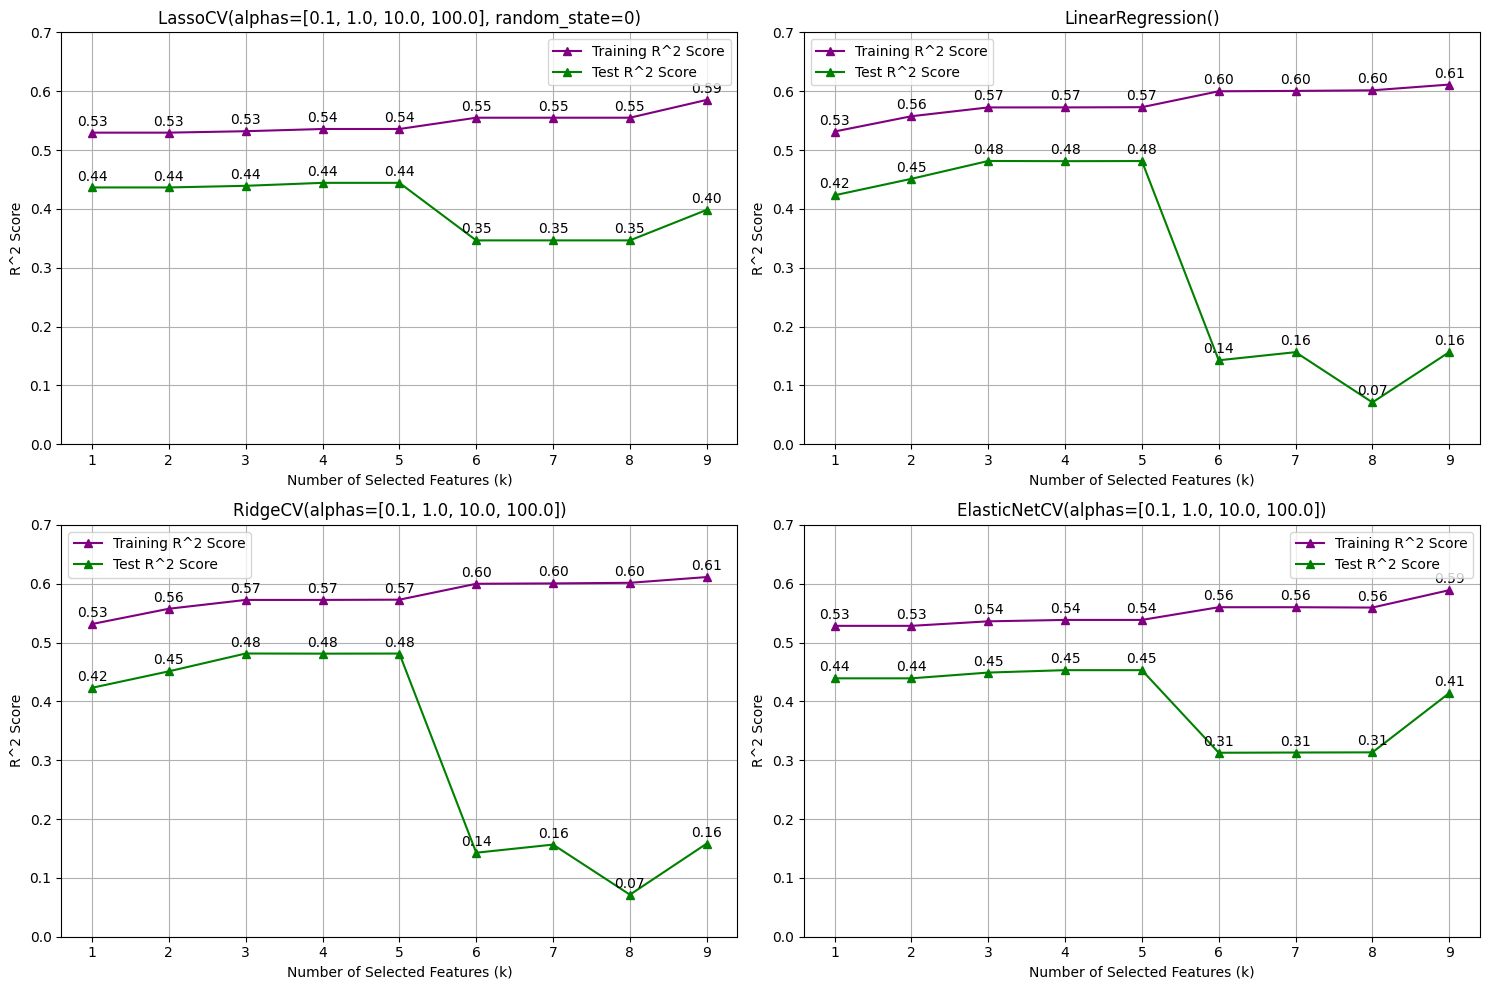

In [ ]:
l_models = {LinearRegression(), LassoCV(random_state=0, alphas=[0.1, 1.0, 10.0, 100.0]), ElasticNetCV(alphas=[0.1, 1.0, 10.0, 100.0]), RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])}
print(l_models)
MSE_safe=dict()
MAE_safe=dict()
features_k3=dict()


fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, model in enumerate(l_models):
    test_score=[]
    train_score=[]
    MSE_score=[]
    MAE_score=[]
    k_feat=dict()



    for K in range(1,10):
        Fselect = SelectKBest(score_func=f_regression, k=K)
        Fselect.fit(X_train_scaled, y1_train)
        X_train_Fselected = Fselect.transform(X_train_scaled)
        X_test_Fselected = Fselect.transform(X_test_scaled)

        l_model = model
        l_model.fit(X_train_Fselected, y1_train)
        test_score.append(l_model.score(X_test_Fselected, y1_test))
        train_score.append(l_model.score(X_train_Fselected, y1_train))
        selected_features_mask = Fselect.get_support()
        selected_features = X_train.columns[selected_features_mask]
        k_feat[K]=selected_features

        MSE_score.append(mean_squared_error(y1_test, model.predict(X_test_Fselected)))
        MAE_score.append(mean_absolute_error(y1_test, model.predict(X_test_Fselected)))


    MSE_safe[model]=MSE_score
    MAE_safe[model]=MAE_score
    features_k3[model]=k_feat[3]

    ax = axs[i // 2, i % 2]
    ax.plot(range(1,10), train_score, label='Training R^2 Score', marker="^", color="purple")
    ax.plot(range(1,10), test_score, label='Test R^2 Score', marker="^", color="green")
    ax.set_title(model)
    ax.set_xlabel('Number of Selected Features (k)')
    ax.set_ylabel('R^2 Score')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0,0.7)



    for j in range(1, 10):
        ax.annotate(f'{train_score[j-1]:.2f}', (j, train_score[j-1]), textcoords="offset points", xytext=(0,5), ha='center')
        ax.annotate(f'{test_score[j-1]:.2f}', (j, test_score[j-1]), textcoords="offset points", xytext=(0,5), ha='center')


plt.tight_layout()
plt.show()


Additionaly to the R^2 scores, we can provide MSE and MAE for the best selected features: TIT, TEY, CDP. All models are coordinated in their results.

In [ ]:
MSE_data=pd.DataFrame.from_dict(MSE_safe, orient="index", columns=range(1,10))
MAE_data=pd.DataFrame.from_dict(MAE_safe, orient="index", columns=range(1,10))
k3_data=pd.DataFrame.from_dict(features_k3, orient="index")
print("MSE:", MSE_data[[3]])
print("\n", "MAE:",MAE_data[[3]])
print("\n", "3 Selected features:",k3_data)

MSE:                                                            3
LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], random_...  2.688198
LinearRegression()                                  2.486046
RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])             2.486178
ElasticNetCV(alphas=[0.1, 1.0, 10.0, 100.0])        2.641463

 MAE:                                                            3
LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], random_...  1.049646
LinearRegression()                                  1.049792
RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])             1.049782
ElasticNetCV(alphas=[0.1, 1.0, 10.0, 100.0])        1.030444

 3 Selected features:                                                       0    1    2
LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], random_...  TIT  TEY  CDP
LinearRegression()                                  TIT  TEY  CDP
RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])             TIT  TEY  CDP
ElasticNetCV(alphas=[0.1, 1.0, 10.0, 100.0])        TIT  TEY  CDP


b) Model-Based Feature Selection. Unlike with Univariate Statistics, the LinearRegression turned out to have the worst indicators of prediction accuracy. However other models didn't manage to reach better results with the feature selection than Univariate Statistics. On the other hand there is more Selected Features, namely: 'AT', 'AFDP', 'GTEP', 'TIT', 'TAT'. Only "TIT" got choosen twice wich suggests importance of this variable.

In [ ]:
Uselect = SelectFromModel(RandomForestRegressor(n_estimators=300, random_state=0, max_depth=15), threshold="median")
Uselect.fit(X_train_scaled, y1_train)
X_train_Uselected = Uselect.transform(X_train_scaled)
X_test_Uselected = Uselect.transform(X_test_scaled)


In [ ]:
Rscores_safe=dict()
for model in l_models:
    l_model = model
    l_model.fit(X_train_Uselected, y1_train)
    train_pred=round(l_model.score(X_train_Uselected, y1_train),3)
    test_pred=round(l_model.score(X_test_Uselected, y1_test),3)
    mse=round(mean_squared_error(y1_test, model.predict(X_test_Uselected)),3)
    mae=round(mean_absolute_error(y1_test, model.predict(X_test_Uselected)),3)
    selected_features_mask = Uselect.get_support()
    selected_features = X_train.columns[selected_features_mask]
    Rscores_safe[model] = [train_pred, test_pred, mse, mae, selected_features]
    # print("R^2 score of training set: {:.3f}".format(l_model.score(X_train_Uselected, y1_train)))
    # print("R^2 score of test set: {:.3f}".format(l_model.score(X_test_Uselected, y1_test)))
    # print(Rscores_data[model])
Rscores_data=pd.DataFrame.from_dict(Rscores_safe, orient="index", columns=["R^2 Train", "R^2 Test", "MSE", "MAE", "Selected Features"])
print(Rscores_data)

                                                    R^2 Train  R^2 Test  \
LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], random_...      0.563     0.486   
LinearRegression()                                      0.571     0.447   
RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])                 0.571     0.451   
ElasticNetCV(alphas=[0.1, 1.0, 10.0, 100.0])            0.562     0.491   

                                                      MSE    MAE  \
LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], random_...  2.465  1.002   
LinearRegression()                                  2.650  1.069   
RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])             2.632  1.065   
ElasticNetCV(alphas=[0.1, 1.0, 10.0, 100.0])        2.440  0.986   

                                                                                    Selected Features  
LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], random_...  Index(['AT', 'AFDP', 'GTEP', 'TIT', 'TAT'], dt...  
LinearRegression()                                  Index(['AT', 'AFDP', 'G

Conclusion on regression. All in all, the best prediction model turned out to be Gradient Boosting Regressor. Their indicators of accuracy tend to be higher then for linear models, providing us with the better explanation of the variance in the data, without overfitting the data as the Random Forests model do.

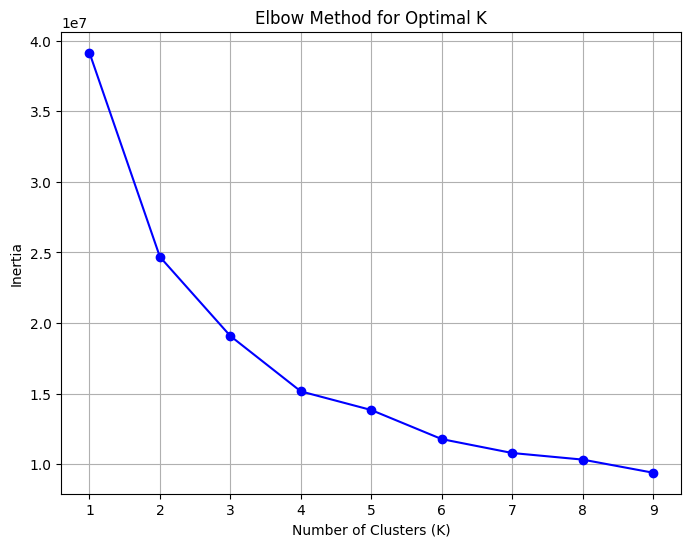

In [ ]:
data_excluded = data_cleaned.drop(columns="Year")
K_values = range(1, 10)

inertia = []

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_excluded)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_values, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

Text(0, 0.5, 'Feature 1')

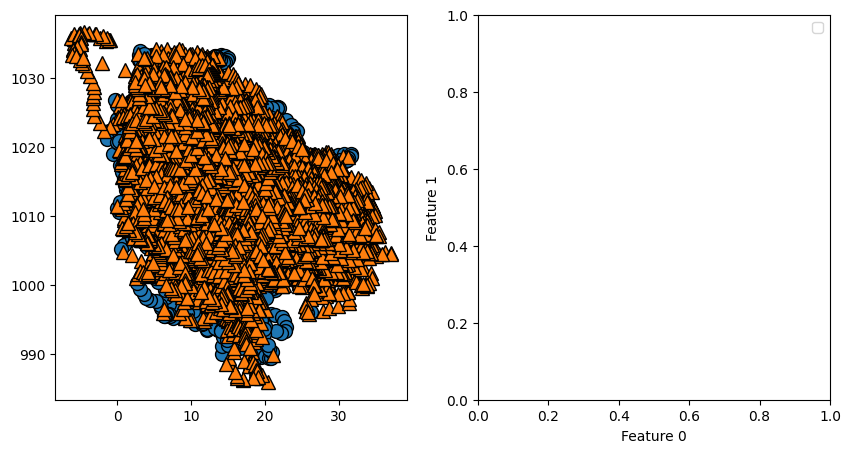

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# using two cluster centers:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_excluded)
assignments = kmeans.labels_

# Access the columns by name
mglearn.discrete_scatter(data_excluded.iloc[:, 0], data_excluded.iloc[:, 1], assignments, ax=axes[0])
#or
# mglearn.discrete_scatter(data[data.columns[0]], data[data.columns[1]], assignments, ax=axes[0])

plt.legend(["cluster 0", "cluster 1", "cluster 2"], loc='best')
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(columns="Year"))
pca = PCA(n_components=4)
pca.fit(data_scaled)
Cum_exp_var=1-pca.explained_variance_ratio_

Explained Variance using PCA: [0.47998972 0.19902934 0.09447527 0.07633334]


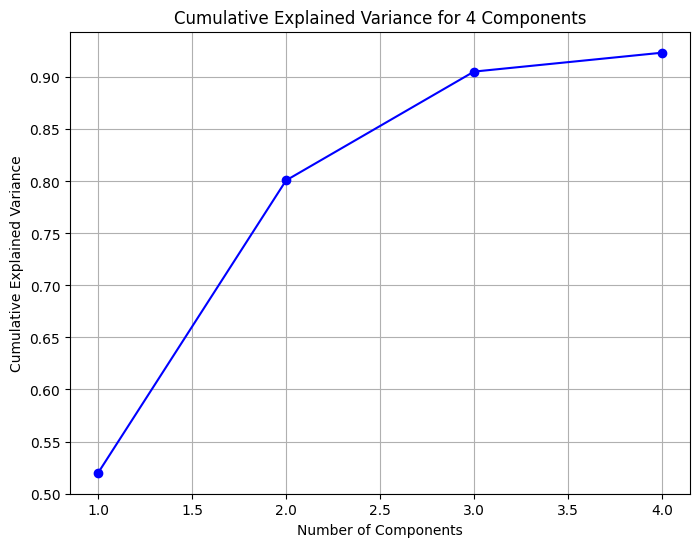

In [ ]:
n_components = range(1, 5)
plt.figure(figsize=(8, 6))
plt.plot(n_components, Cum_exp_var, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Сomponents')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()